In [1]:
import sys 
sys.path.append('./scripts/')
from robot import *
from scipy.stats import multivariate_normal
import random #追加
import copy

In [2]:
class Particle: 
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):  #変更_
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            ##パーティクルの位置と地図からランドマークの距離と方角を算出##
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            ##尤度の計算##
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)

In [3]:
class Mcl:    ###mlparticle（12〜18行目）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        self.ml = self.particles[0] #追加
        self.pose = self.ml.pose #追加（互換性のため）
        
    def set_ml(self): #追加
        i = np.argmax([p.weight for p in self.particles])
        self.ml = self.particles[i]
        self.pose = self.ml.pose
        
    def motion_update(self, nu, omega, time): 
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation): 
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
        self.set_ml() #リサンプリング前に実行
        self.resampling() 
            
    def resampling(self): ###systematicsampling
        ws = np.cumsum([e.weight for e in self.particles]) #重みを累積して足していく（最後の要素が重みの合計になる）
        if ws[-1] < 1e-100: ws = [e + 1e-100 for e in ws]  #重みの合計が0のときの処理
            
        step = ws[-1]/len(self.particles)   #正規化されていない場合はステップが「重みの合計値/N」になる
        r = np.random.uniform(0.0, step)
        cur_pos = 0
        ps = []            #抽出するパーティクルのリスト
        
        while(len(ps) < len(self.particles)):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])  #もしかしたらcur_posがはみ出るかもしれませんが例外処理は割愛で
                r += step
            else:
                cur_pos += 1

        self.particles = [copy.deepcopy(e) for e in ps]                   #以下の処理は前の実装と同じ
        for p in self.particles: p.weight = 1.0/len(self.particles)
        
    def draw(self, ax, elems):  
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) for p in self.particles] #重みを要素に反映
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) for p in self.particles]  #重みを要素に反映
        elems.append(ax.quiver(xs, ys, vxs, vys, \
                               angles='xy', scale_units='xy', scale=1.5, color="blue", alpha=0.5)) #変更

In [4]:
class EstimationAgent(Agent): 
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None): 
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems): ###mlwrite
        self.estimator.draw(ax, elems)
        x, y, t = self.estimator.pose #以下追加
        s = "({:.2f}, {:.2f}, {})".format(x,y,int(t*180/math.pi)%360)
        elems.append(ax.text(x, y+0.1, s, fontsize=8))

<IPython.core.display.Javascript object>


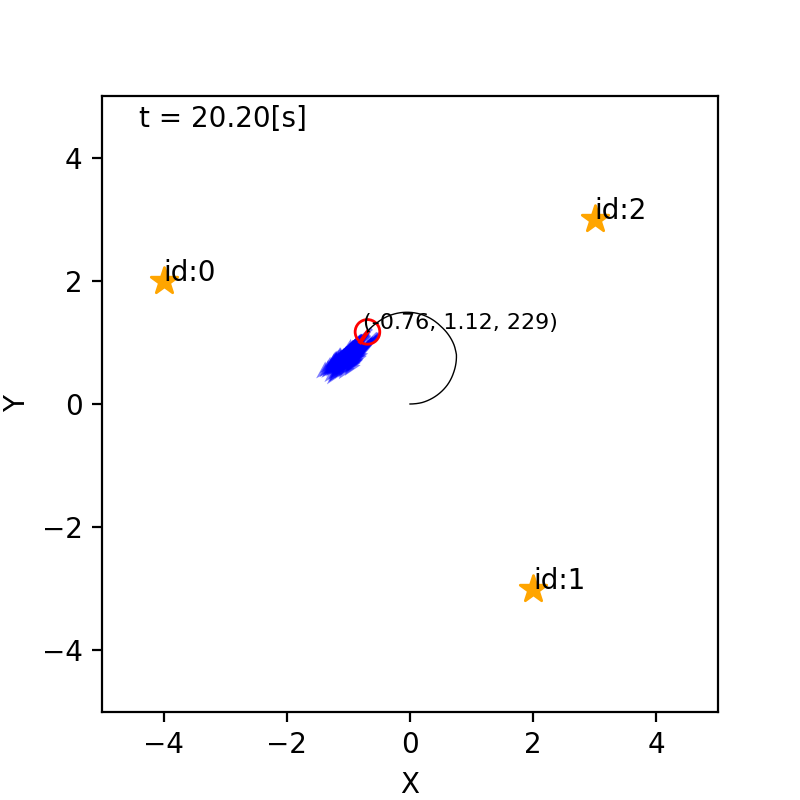

In [6]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)          

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(m, initial_pose, 100) #地図mを渡す
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
trial()